In [1]:
from __future__ import division
import os
import numpy as np
from neuron import h, gui
import matplotlib.pyplot as plt
plt.ion()


### Build ball and stick model


In [2]:
soma = h.Section(name="soma")
soma.L = 25
soma.diam = 25
soma.Ra = 100
soma.insert("pas")
soma.g_pas = 1 / 20000.
v_rest = -60
soma.e_pas = v_rest
soma.insert('na')
soma.gbar_na = 5000
soma.insert('kv')
soma.gbar_kv = 1500
h.celsius = 30

dend = h.Section(name="dend")
dend.L = 700  
dend.diam = 1    
dend.Ra = 100 
dend.insert("pas")
dend.e_pas = v_rest
dend.g_pas = 1 / 20000.
dend.connect(soma, 1, 0)

# set number of segement
h("forall { nseg = int((L/(0.1*lambda_f(100))+0.9)/2)*2 + 1 }")
h.define_shape()

ValueError: argument not a density mechanism name.

### Set up synapses and recordings

In [3]:
# create 20 excitatory synapses:
hotspot_NMDA_synapses = []
hotspot_NMDA_netcons = []
hotspot_NMDA_netstims = []
for j in range(20):
    hotspot_NMDA_synapses.append(h.ProbAMPANMDA2_RATIO(dend(0.6)))
    hotspot_NMDA_netstims.append(h.NetStim())
    hotspot_NMDA_netcons.append(h.NetCon(hotspot_NMDA_netstims[j], hotspot_NMDA_synapses[j]))
    hotspot_NMDA_synapses[j].tau_r_AMPA = 0.33
    hotspot_NMDA_synapses[j].tau_d_AMPA = 1
    hotspot_NMDA_synapses[j].e = 0
    hotspot_NMDA_synapses[j].tau_r_NMDA = 0.23
    hotspot_NMDA_synapses[j].tau_d_NMDA = 55
    hotspot_NMDA_netcons[j].weight[0]= 0.5
    hotspot_NMDA_netstims[j].number = 9e9
    hotspot_NMDA_netstims[j].noise = 1
    hotspot_NMDA_netstims[j].interval = 50  # mean time between spikes |50 ms = 20 Hz|

# create 1 inhibitory synapse at location 0.2
on_path_inhibition = h.Exp2Syn(dend(0.2)) 
on_path_inhibition.tau1 = 0.01
on_path_inhibition.tau2 = 9e9
on_path_inhibition.e = v_rest
# create 1 inhibitory synapse at location 0.99
off_path_inhibition  = h.Exp2Syn(dend(0.99))
off_path_inhibition.tau1 = 0.01
off_path_inhibition.tau2 = 9e9
off_path_inhibition.e = v_rest
# create a NetStim that will activate the synapses at t=1000
inhibition_netstim = h.NetStim()
inhibition_netstim.number = 1
inhibition_netstim.start = 1000
inhibition_netstim.noise = 0
on_path_netcon  = h.NetCon(inhibition_netstim, on_path_inhibition)
off_path_netcon = h.NetCon(inhibition_netstim, off_path_inhibition)

In [4]:
# recording
soma_v = h.Vector()
soma_v.record(soma(0.5)._ref_v)
dend_vs = []
for seg in dend:  # record voltage from all segments in the dendrite
    dend_vs.append(h.Vector())
    dend_vs[-1].record(seg._ref_v)
t = h.Vector()
t.record(h._ref_t);

### Run simulations, plot results

In [5]:
# general settings
h.v_init = v_rest
h.tstop = 5000

inhibition_weight = 0.0045
# Run simulation with proximal inhibition
on_path_netcon.weight[0] = inhibition_weight
off_path_netcon.weight[0] = 0
h.run()
soma_v_proximal_inh = list(soma_v)
# Run simulation with distal inhibition
on_path_netcon.weight[0]  = 0
off_path_netcon.weight[0] = inhibition_weight
h.run()
soma_v_distal_inh = list(soma_v)

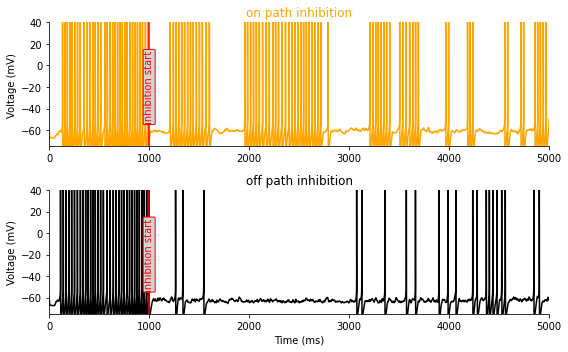

In [6]:
plt.figure(figsize=(8, 5))
ax = plt.subplot(2, 1, 1)
ax.plot(t, soma_v_proximal_inh, color='orange', label='on path\ninhibition')
ax.plot([1000,1000], [-75,40], 'red')
ax.text(950, -20,'inhibition start', color='red',rotation=90, va='center',
        bbox=dict(facecolor='lightgray', edgecolor='red', pad=0.5, boxstyle='round,pad=0.1'))
ax.set_ylabel('Voltage (mV)')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title('on path inhibition', color='orange')

ax2 = plt.subplot(2, 1, 2, sharex=ax, sharey=ax)
ax2.plot(t, soma_v_distal_inh, color='black', label='off path\ninhibition')
ax2.plot([1000,1000], [-75,40], 'red')
ax2.text(950, -20, 'inhibition start', color='red', rotation=90, va='center',
         bbox=dict(facecolor='lightgray', edgecolor='red', pad=0.5, boxstyle='round,pad=0.1'))
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Voltage (mV)')
ax2.set_title('off path inhibition')
ax2.set_xlim([0, 5000])
ax2.set_ylim([-75, 40])
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
plt.tight_layout()